In [55]:
# load the files
import pandas as pd
import json
train_set = json.load(open('train.json'))
dev_set = json.load(open('dev.json'))
test_set = json.load(open('test-unlabelled.json'))

In [56]:

train_data = []
train_label = []
for i in range(len(train_set)):
    train_data.append(train_set['train-'+str(i)]['text'])
    train_label.append('train-'+str(i))

test_data = []
test_label = []
for i in range(len(test_set)):
    test_data.append(test_set['test-'+str(i)]['text'])
    test_label.append('test-'+str(i))

dev_data = []
dev_label = []
dev_isfake = []
for i in range(len(dev_set)):
    dev_data.append(dev_set['dev-'+str(i)]['text'])
    dev_label.append('dev-'+str(i))
    dev_isfake.append(dev_set['dev-'+str(i)]['label'])

In [57]:
### Comment if readinf from file###

train_false1 = pd.read_csv('articles2.csv')
train_false2 = pd.read_csv('articles3.csv')


pattern = 'climate change|global warming'

train_false2 = train_false2[train_false2.title.str.contains(pattern, na=False)]
train_false2 = train_false2[['content']]
train_false2 = train_false2.rename(columns={'content': 'data'})
train_false2['isfake'] = 0
train_false1 = train_false1[['content']]
train_false1 = train_false1.rename(columns={'content': 'data'})
train_false1['isfake'] = 0
list_of_tuples_dev = list(zip(dev_data, dev_isfake))  
traindf = pd.DataFrame(data = train_data , columns=['data'])
traindf['isfake'] = 1
testdf = pd.DataFrame(data = test_data , columns=['data'])
devdf = pd.DataFrame(data = list_of_tuples_dev , columns=['data', 'isfake'])

train_data_df = pd.concat([traindf, train_false1])



In [58]:
df_fake = train_data_df[train_data_df['isfake'] == 1] 
df_true = train_data_df[train_data_df['isfake'] == 0] 
df_true = df_true.sample(n=len(df_fake))
df_true = df_true.head(1068)
df_true = pd.concat([df_true, train_false2])
df = df_true.append(df_fake)
df = df.sample(frac=1, random_state = 24).reset_index(drop=True)


In [84]:
len(df)

2336

In [ ]:
## uncomment if reading directly
#df = pd.read_csv('full_training_set.csv') 


In [85]:
# df.to_csv('full_training_set.csv')

In [82]:
len(df_true)

1168

In [83]:
# df_true.to_csv('true_news_custom.csv')

In [60]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

In [61]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [62]:
df['data'] = df['data'].map(lambda x: clean_text(x))
testdf['data'] = testdf['data'].map(lambda x: clean_text(x))
devdf['data'] = devdf['data'].map(lambda x: clean_text(x))






In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [64]:
    #further cleaning
    df['data'] = df['data'].str.replace('[^\w\s]',' ')

    df['data'] = df['data'].str.replace('[^A-Za-z]',' ')
    
    testdf['data'] = testdf['data'].str.replace('[^\w\s]',' ')

    testdf['data'] = testdf['data'].str.replace('[^A-Za-z]',' ')
    
    devdf['data'] = devdf['data'].str.replace('[^\w\s]',' ')

    devdf['data'] = devdf['data'].str.replace('[^A-Za-z]',' ')

In [65]:
len(df)

2336

In [66]:

mask_on = df['isfake'] == 1
df_fake = df[mask_on]['data']

cv1 = CountVectorizer(stop_words = 'english')

fake_cvec = cv1.fit_transform(df_fake)

fake_cvec_df = pd.DataFrame(fake_cvec.toarray(),
                   columns=cv1.get_feature_names())

print(fake_cvec_df.shape)

(1168, 15635)


In [67]:
mask_no = df['isfake'] == 0
df_real = df[mask_no]['data']

cv2 = CountVectorizer(stop_words = 'english')

real_cvec = cv2.fit_transform(df_real)

real_cvec_df = pd.DataFrame(real_cvec.toarray(),
                   columns=cv2.get_feature_names())

print(real_cvec_df.shape)

(1168, 24098)


In [68]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

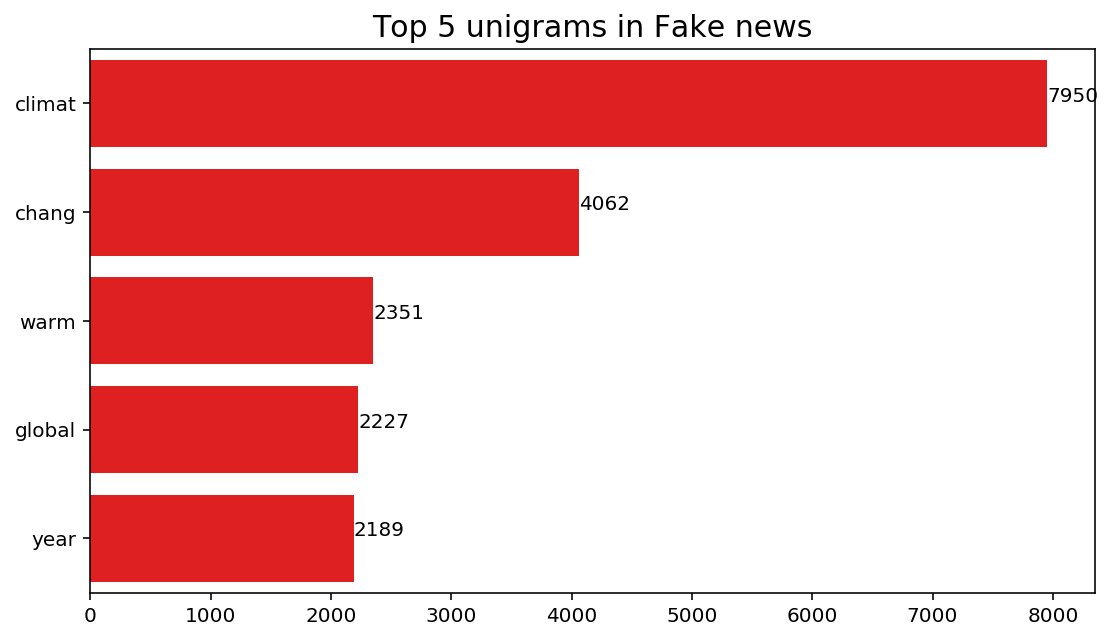

In [69]:
#  top 5 most used words in Fake news
fake_wc = fake_cvec_df.sum(axis = 0)
fake_top_5 = fake_wc.sort_values(ascending=False).head(5)

bar_plot(fake_top_5.values, fake_top_5.index, 'Top 5 unigrams in Fake news','r')

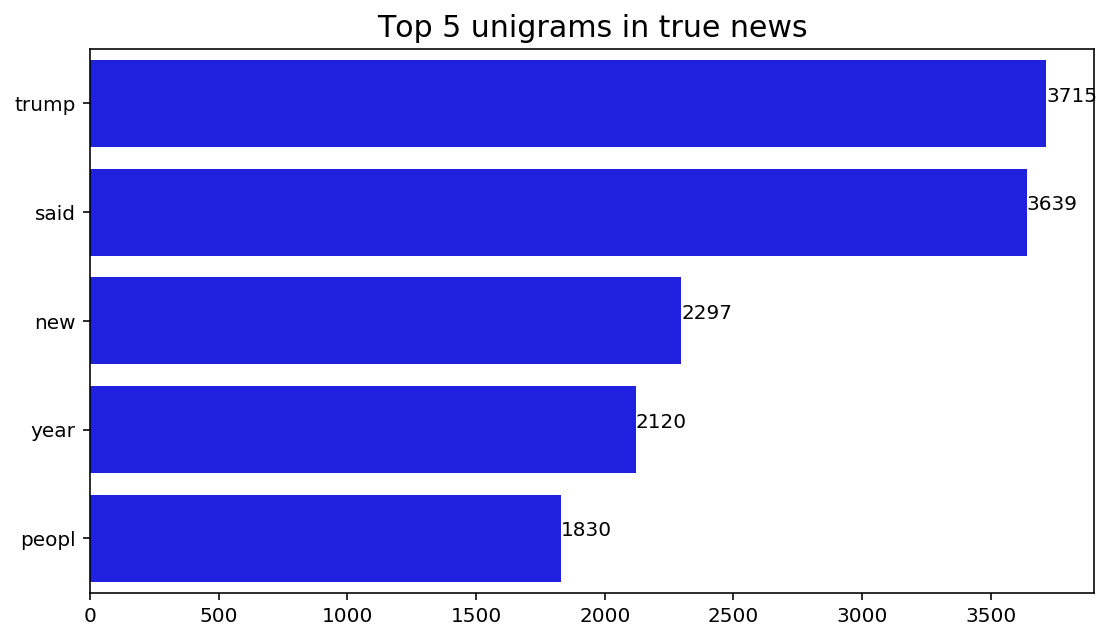

In [70]:
real_wc = real_cvec_df.sum(axis = 0)
real_top_5 = real_wc.sort_values(ascending=False).head(5)

bar_plot(real_top_5.values, real_top_5.index, 'Top 5 unigrams in true news','b')

In [71]:
# Create list of unique words in top five
real_5_set = set(real_top_5.index)
fake_5_set = set(fake_top_5.index)

# Return common words
common_unigrams = fake_5_set.intersection(real_5_set)
common_unigrams

{'year'}

In [72]:

mask = df['isfake'] == 1
df_fake_data = df[mask]['data']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
fake_cvec = cv.fit_transform(df_fake_data)

# Convert into a DataFrame
fake_cvec_df = pd.DataFrame(fake_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head 
print(fake_cvec_df.shape)

(1168, 213763)


In [73]:
# Set variables to show NotTheOnion Titles
mask = df['isfake'] == 0
df_real_data = df[mask]['data']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
real_cvec = cv.fit_transform(df_real_data)

# Convert onion_cvec into a DataFrame
real_cvec_df = pd.DataFrame(real_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(real_cvec_df.shape)

(1168, 318151)


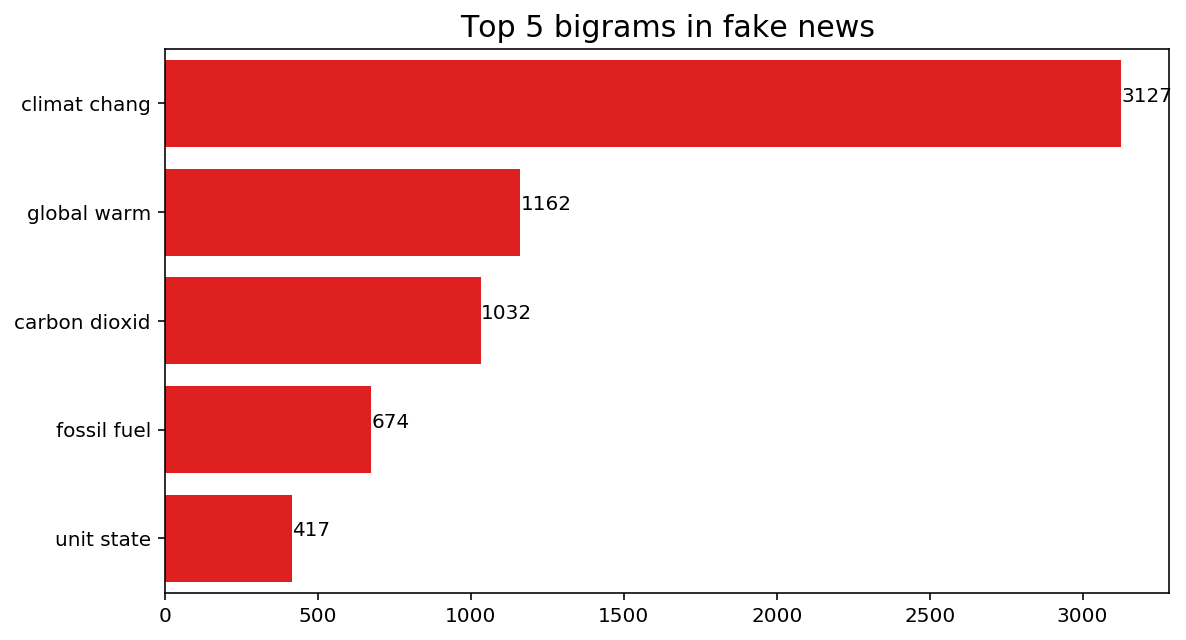

In [74]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
fake_wc = fake_cvec_df.sum(axis = 0)
fake_top_5 = fake_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(fake_top_5.values, fake_top_5.index, 'Top 5 bigrams in fake news','r')

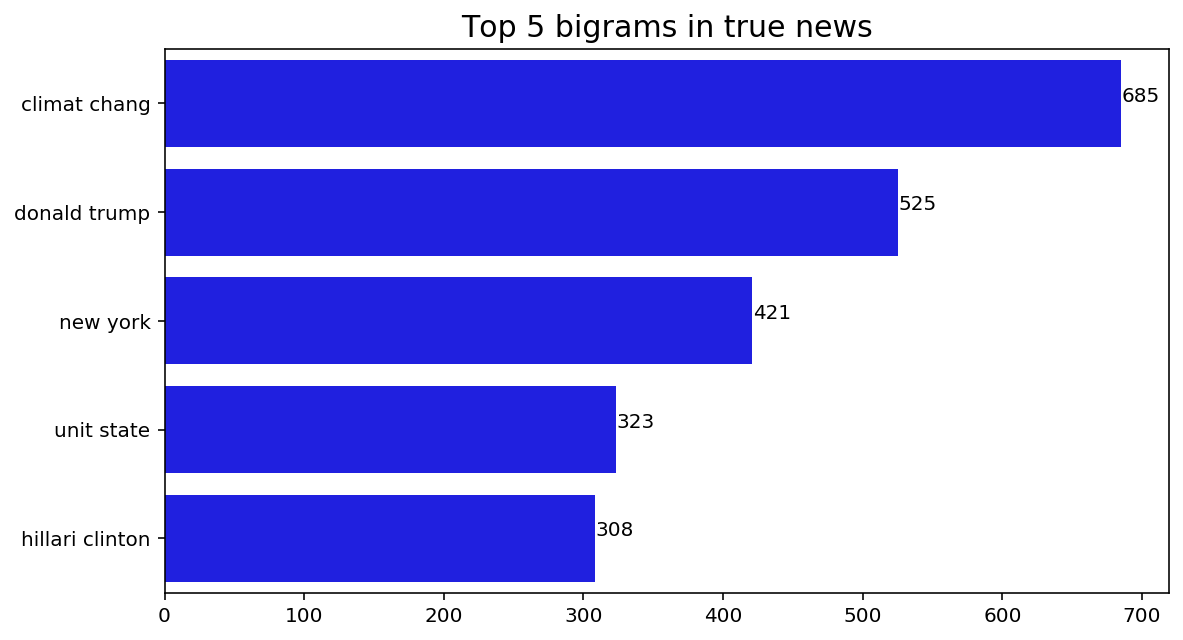

In [75]:
real_wc = real_cvec_df.sum(axis = 0)
real_top_5 = real_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(real_top_5.values, real_top_5.index, 'Top 5 bigrams in true news','b')

In [76]:
real_5_list = set(real_top_5.index)
fake_5_list = set(fake_top_5.index)

# Return common words
common_bigrams = fake_5_list.intersection(real_5_list)
common_bigrams

{'climat chang', 'unit state'}

In [77]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

In [78]:

# Baseline score
df['isfake'].value_counts(normalize=True)

1    0.5
0    0.5
Name: isfake, dtype: float64

In [79]:
X = df['data']
y = df['isfake']

In [80]:

X_train, X_test, y_train, y_test = df['data'], devdf['data'], df['isfake'], devdf['isfake']

In [135]:
#Model 1 CountVectorizer & Logistic Regression (Best Coefficient Interpretability
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.9606164383561644
Train score 0.9885844748858448
Test score 0.952054794520548


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 0.01}

In [136]:
#Model 2 
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.9526255707762558
Train score 0.9743150684931506
Test score 0.964041095890411


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 3)}

In [137]:
#Model 3
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.9606164383561644
Train score 1.0
Test score 0.9623287671232876


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}

In [138]:
#model 4
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.9606164383561644
Train score 0.9726027397260274
Test score 0.9571917808219178


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

In [ ]:
LogisticRegression

In [139]:
#Instantiate the classifier and vectorizer



lr = LogisticRegression(C = 1)
tfidf = TfidfVectorizer(ngram_range= (1, 3), min_df = 5,max_df = 0.75)

# Fit and transform the vectorizor
tfidf.fit(df['data'])

Xtfidf_train = tfidf.transform(df['data'])
Xtfidf_test = tfidf.transform(devdf['data'])

# Fit the classifier
lr.fit(Xtfidf_train,df['isfake'])

# Create the predictions for Y training data
preds = lr.predict(Xtfidf_test)

print(lr.score(Xtfidf_test, devdf['isfake']))

0.76


/Users/haripriyaramesh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [140]:
#Instantiate the classifier and vectorizer



nb = MultinomialNB(alpha = 0.1)
tfidf = TfidfVectorizer(ngram_range= (1, 2), min_df = 4,max_df = 0.75)

# Fit and transform the vectorizor
tfidf.fit(df['data'])

Xtfidf_train = tfidf.transform(df['data'])
Xtfidf_test = tfidf.transform(devdf['data'])

# Fit the classifier
nb.fit(Xtfidf_train,df['isfake'])

# Create the predictions for Y training data
preds = nb.predict(Xtfidf_test)

print(nb.score(Xtfidf_test, devdf['isfake']))

0.71


In [141]:
#Instantiate the classifier and vectorizer



nb = MultinomialNB(alpha = 0.6)
tfidf = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
tfidf.fit(df['data'])

Xtfidf_train = tfidf.transform(df['data'])
Xtfidf_test = tfidf.transform(devdf['data'])

# Fit the classifier
nb.fit(Xtfidf_train,df['isfake'])

# Create the predictions for Y training data
preds = nb.predict(Xtfidf_test)

print(nb.score(Xtfidf_test, devdf['isfake']))

0.71


In [146]:

lr = LogisticRegression(C = 0.01)
cv = CountVectorizer(ngram_range= (1, 1))

# Fit and transform the vectorizor
cv.fit(df['data'])

Xcv_train = cv.transform(df['data'])
Xcv_dev = cv.transform(devdf['data'])
Xcv_test = cv.transform(testdf['data'])



# Fit the classifier
lr.fit(Xcv_train,df['isfake'])

# Create the predictions for Y training data
preds_test = lr.predict(Xcv_test)
preds_dev = lr.predict(Xcv_dev)



print(nb.score(Xtfidf_test, devdf['isfake']))

/Users/haripriyaramesh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [149]:
preds_dev.tolist()
preds_test.tolist()

[1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [151]:
jsondata = {}
label={}
alljsons = []
jsondata['a'] = {}
for i in range(len(dev_set)):
    label={}
    label['label']=int(preds_dev[i])
    jsondata['a']['dev-'+str(i)] =label
    

In [152]:
with open('dev-output.json', 'w', encoding='utf-8') as f:
    json.dump(jsondata, f, ensure_ascii=False, indent=4)

In [153]:
jsondata = {}
label={}
alljsons = []
jsondata['a'] = {}
for i in range(len(test_set)):
    label={}
    label['label']=int(preds_test[i])
    jsondata['a']['test-'+str(i)] =label

In [154]:
with open('test-output.json', 'w', encoding='utf-8') as f:
    json.dump(jsondata, f, ensure_ascii=False, indent=4)